# WEST ICRH Antenna RF Model
## The WEST ICRH antennas 
Three identical ELM-resilient and CW power ICRH antennas have been designed for WEST. The ELM resilience property is obtained through an internal conjugate-T electrical scheme with series capacitors. An antenna has 4 straps (2 toroidal x 2 poloidal) and is fed by 2 generators (left side and right side). Each antenna is equipped with four internal COMET® tuneable vacuum capacitors, with capacitances ranging from 15 pF to 150 pF and specifically upgraded for CW operation. A two-stage quarter-wavelength and water cooled impedance transformer is connected from the T-junction to the vacuum feedthrough.

<img src="West_Antenna_1.png" width="600"/>

<img src="West_Antenna_2.png" width="600"/>

## WEST IC antenna Python RF Model

In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

The WEST ICRH Antenna RF model can be built be eventually defining:
- the frequency band of interest, given by a scikit-rf `Frequency` object
- the front face S-parameter `filename`, ie. the model of the antenna front-face radiating to a given medium
- the capacitor's capacitances `[C1, C2, C3, C4]`

All these parameters are optionnal when builing the `WestIcrhAntenna` object. Default parameters if a frequency band 30-70 MHz, with the front-face radiating in vacuum with all capacitances set to 50 pF.

In [4]:
# default values
antenna = WestIcrhAntenna()
print(antenna)

WEST ICRH Antenna: C=[50, 50, 50, 50] pF, 0.03-0.07 GHz, 4001 pts


For example, to reduce the frequency band of interest:

In [5]:
freq = rf.Frequency(48, 52, npoints=2001, unit='MHz')
antenna = WestIcrhAntenna(frequency=freq)

The antenna circuit can be visualized via the scikit-rf `Circuit` object:

<IPython.core.display.Javascript object>


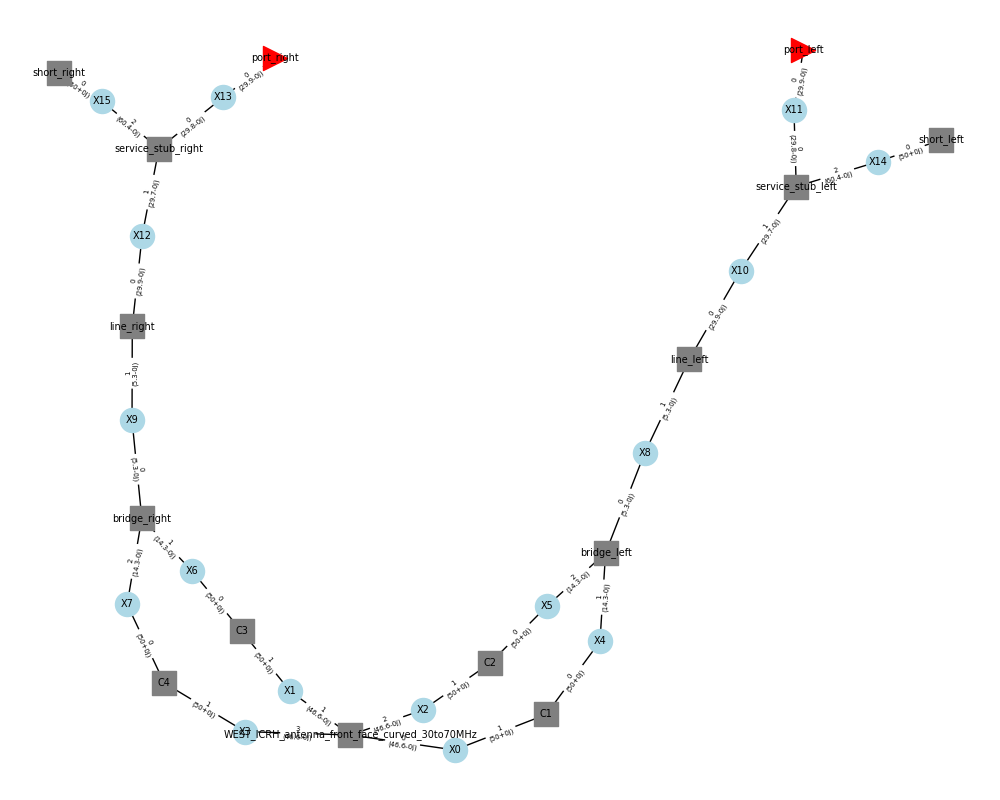

In [9]:
antenna.circuit().plot_graph(network_labels=True, edge_labels=True, 
inter_labels=True, port_labels=True)

## Matching the antenna step by step
Each side of the antenna can be matched separatly, which is what is done in practice. Let's start with the left side, looking for a solution at 50 Mhz, with the solution 1 (corresponding to C_top > C_bot, solution 2 being the opposite). The right side is left unmatched.

In [7]:
f_match = 50e6
C_match_left = antenna.match_one_side(f_match=f_match, side='left', solution_number=1)

True solution #1: [67.52324351 64.61470664]


Once the solution has been found, we setup the antenna capacitors to these values: 

In [8]:
antenna.Cs = C_match_left

Let's have a look to the S-parameters of the antenna, which is a 2-port network. An easy way to plot them is to retrieve the scikit-rf `Network` object and its convenience methods:

<IPython.core.display.Javascript object>


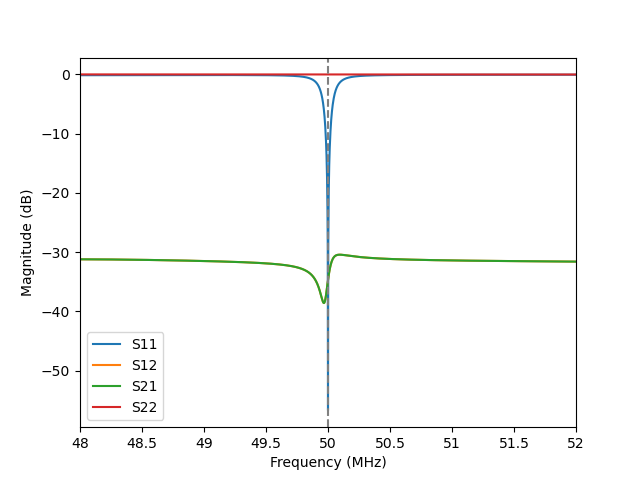

In [9]:
fig, ax = plt.subplots()
antenna.circuit().network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

Now let's match the right side (the left side being unmatched). This time, it will minimize the S22 at the match frequency.

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [59.94497972 12.        ]
True solution #1: [67.29026545 64.84061245]


<IPython.core.display.Javascript object>


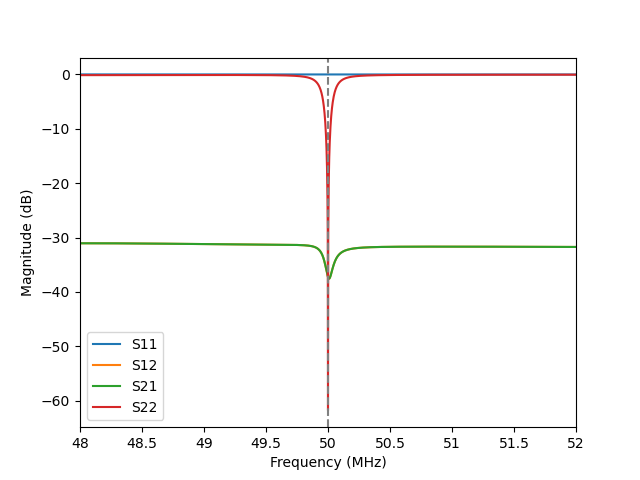

In [10]:
C_match_right = antenna.match_one_side(f_match=f_match, side='right', solution_number=1)
antenna.Cs = C_match_right
fig, ax = plt.subplots()
antenna.circuit().network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

If we setup the antenna with the combination of these two solutions, and zoom into the 48-52 MHz band, one sees that antenna shows two optimized frequencies around the match frequencies.

In [11]:
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
print(C_match)
antenna.Cs = C_match

[67.52324351421422, 64.61470664290033, 67.2902654493288, 64.84061245363814]


<IPython.core.display.Javascript object>


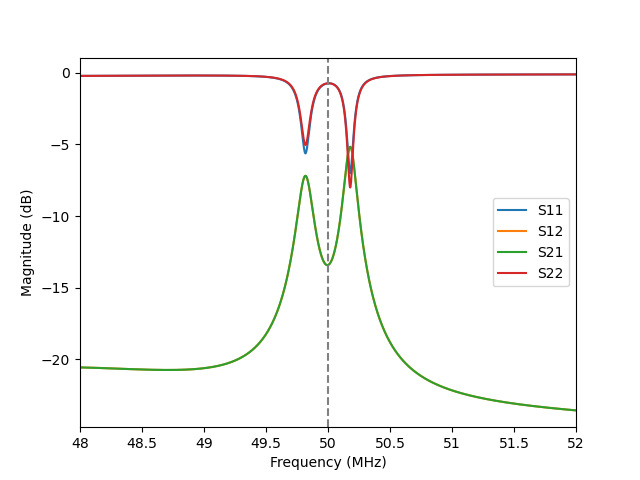

In [12]:
fig, ax = plt.subplots()
antenna.circuit(Cs=C_match).network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

These optimum frequencies correspond to the monopole and dipole excitations. Instead of looking to the S-parameters, it is more meaningfull to look to the 'active' S-parameters, defined by:

$$
S_{act,m} = \sum_{n=1}^M S_{mn} \frac{a_n}{a_m}
$$

with $m=1..N$ where $N$ is the number of ports (here M=2) and $a_k$ the complex excitation for the k-th port.

<IPython.core.display.Javascript object>


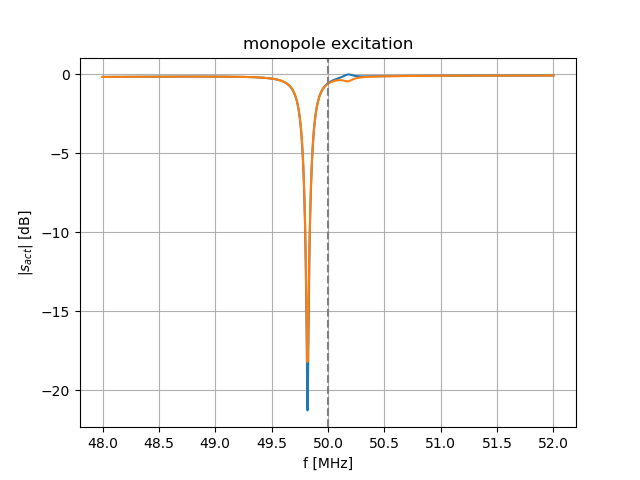

In [13]:
# monopole excitation, left side being the reference
power = [1, 1]
phase = [0, 0]
# getting the active s-parameters
s_act = antenna.s_act(power, phase)
# plotting
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)))
ax.axvline(f_match/1e6, ls='--', color='gray')
ax.set_title('monopole excitation')
ax.set_xlabel('f [MHz]')
ax.set_ylabel('$|s_{act}|$ [dB]')
ax.grid(True)

<IPython.core.display.Javascript object>


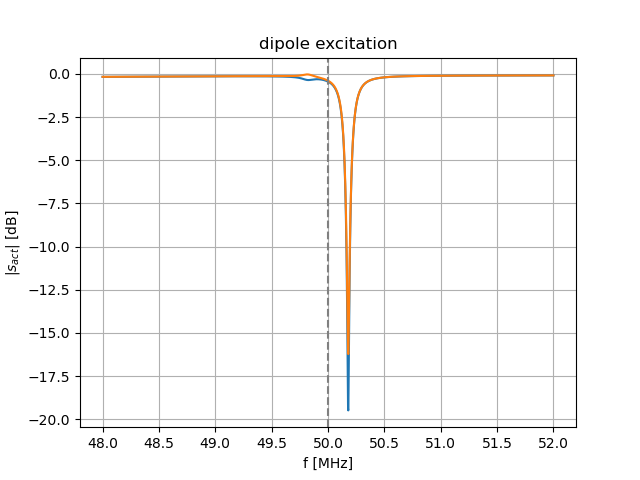

In [14]:
# dipole excitation, left side being the reference
power = [1, 1]
phase = [0, np.pi]
# getting the active s-parameters
s_act = antenna.s_act(power, phase, Cs=C_match)
# plotting
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)))
ax.axvline(f_match/1e6, ls='--', color='gray')
ax.set_title('dipole excitation')
ax.set_xlabel('f [MHz]')
ax.set_ylabel('$|s_{act}|$ [dB]')
ax.grid(True)

## Voltages and Currents

In [15]:
# dipole case, 1 MW input on both sides
power = [1e6, 1e6]
phase = [0, np.pi]

Vs = antenna.voltages(power, phase)
Is = antenna.currents(power, phase)

<IPython.core.display.Javascript object>


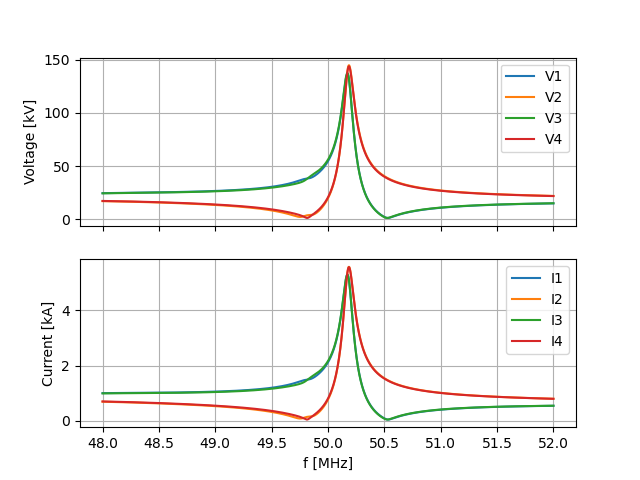

In [16]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(freq.f_scaled, np.abs(Vs)/1e3)
ax[1].plot(freq.f_scaled, np.abs(Is)/1e3)
ax[1].set_xlabel('f [MHz]')
ax[0].set_ylabel('Voltage [kV]')
ax[1].set_ylabel('Current [kA]')
[a.grid(True) for a in ax]
ax[0].legend(('V1','V2','V3','V4'))
ax[1].legend(('I1','I2','I3','I4'))

In [17]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')